# Finetune ResNet50


With 1000 x 400 melspectrogram images with online data augmentation (stochastic Gaussian noise), with a lower maximum standard deviation value


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'resnet50_augmented_stochastic'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define a class to add Gaussian noise to the mel spectrogram images for online data augmentation


In [14]:
from data_augmentation.AddGaussianNoiseStochastic import AddGaussianNoiseStochastic

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [15]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define train transformations, also the online data augmentation
train_transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    AddGaussianNoiseStochastic(mean=0.0, std_range=(0.0, 0.03), p=0.5
                               ),  # Online noise augmentation
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

# Define test transformations for both validation and test sets
test_transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 25

Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.80it/s, Loss=1.7670838832855225, Elapsed=20.6150s, ETA=0.0000s] 


Epoch 1 completed in 73.1715s
Train Loss: 1.4670075991250187 - Train Accuracy: 42.373532936839965
Validation Loss: 1.309586459795634 - Validation Accuracy: 48.723089911355

Epoch 2/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.78it/s, Loss=1.8115862607955933, Elapsed=20.5233s, ETA=0.0000s] 


Epoch 2 completed in 73.2616s
Train Loss: 1.3194495442974774 - Train Accuracy: 47.981728138214876
Validation Loss: 1.3106633059183757 - Validation Accuracy: 49.53566905867455

Epoch 3/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.79it/s, Loss=1.4538644552230835, Elapsed=20.5531s, ETA=0.0000s] 


Epoch 3 completed in 73.4545s
Train Loss: 1.2791634319145555 - Train Accuracy: 50.01243752968046
Validation Loss: 1.2908412329355876 - Validation Accuracy: 50.60151962853525

Epoch 4/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.80it/s, Loss=1.5211961269378662, Elapsed=20.7050s, ETA=0.0000s] 


Epoch 4 completed in 73.4431s
Train Loss: 1.2559706999387354 - Train Accuracy: 50.98934895185545
Validation Loss: 1.233527266184489 - Validation Accuracy: 52.02617138032926

Epoch 5/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.76it/s, Loss=1.4912879467010498, Elapsed=20.4724s, ETA=0.0000s] 


Epoch 5 completed in 73.0972s
Train Loss: 1.2391679934683564 - Train Accuracy: 51.46197507971326
Validation Loss: 1.203793166478475 - Validation Accuracy: 53.38750527648797

Epoch 6/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.65it/s, Loss=1.5310229063034058, Elapsed=20.7743s, ETA=0.0000s] 


Epoch 6 completed in 73.3991s
Train Loss: 1.2296810343086375 - Train Accuracy: 52.02731733791638
Validation Loss: 1.1947011391321818 - Validation Accuracy: 54.105107640354575

Epoch 7/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.77it/s, Loss=1.2731448411941528, Elapsed=20.5559s, ETA=0.0000s] 


Epoch 7 completed in 73.2548s
Train Loss: 1.2177809680128373 - Train Accuracy: 52.556477691594495
Validation Loss: 1.2313721211751303 - Validation Accuracy: 52.58547910510764

Epoch 8/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.59it/s, Loss=1.3116494417190552, Elapsed=20.7067s, ETA=0.0000s] 


Epoch 8 completed in 73.4779s
Train Loss: 1.2091219008313439 - Train Accuracy: 52.746432690350744
Validation Loss: 1.1903697792689005 - Validation Accuracy: 53.74630645842128

Epoch 9/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.74it/s, Loss=1.362715244293213, Elapsed=20.6808s, ETA=0.0000s]  


Epoch 9 completed in 73.3235s
Train Loss: 1.1990322537849405 - Train Accuracy: 53.40675244793198
Validation Loss: 1.1964396890004476 - Validation Accuracy: 53.777965386238925

Epoch 10/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.73it/s, Loss=1.3978900909423828, Elapsed=20.5507s, ETA=0.0000s] 


Epoch 10 completed in 73.2328s
Train Loss: 1.1901302409998944 - Train Accuracy: 53.99470839646322
Validation Loss: 1.1886640707651774 - Validation Accuracy: 54.0523427606585

Epoch 11/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.76it/s, Loss=1.0657105445861816, Elapsed=20.6775s, ETA=0.0000s] 


Epoch 11 completed in 73.4763s
Train Loss: 1.189142922273261 - Train Accuracy: 53.58540060152416
Validation Loss: 1.2109148438771566 - Validation Accuracy: 53.49303503588012

Epoch 12/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.74it/s, Loss=1.5382466316223145, Elapsed=20.5501s, ETA=0.0000s] 


Epoch 12 completed in 73.1630s
Train Loss: 1.1798743621117807 - Train Accuracy: 54.13717464553041
Validation Loss: 1.1682424251238506 - Validation Accuracy: 55.21317011397214

Epoch 13/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.70it/s, Loss=1.414453148841858, Elapsed=20.6949s, ETA=0.0000s]  


Epoch 13 completed in 73.2803s
Train Loss: 1.172383483606956 - Train Accuracy: 54.40627756043509
Validation Loss: 1.170801239013672 - Validation Accuracy: 55.33980582524271

Epoch 14/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.73it/s, Loss=1.0846788883209229, Elapsed=20.6095s, ETA=0.0000s] 


Epoch 14 completed in 73.2424s
Train Loss: 1.1708783702009675 - Train Accuracy: 54.93996065217883
Validation Loss: 1.1550663487116495 - Validation Accuracy: 55.12874630645842

Epoch 15/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.78it/s, Loss=1.3868870735168457, Elapsed=20.5437s, ETA=0.0000s] 


Epoch 15 completed in 73.1689s
Train Loss: 1.1564543829487928 - Train Accuracy: 55.170620293525694
Validation Loss: 1.14794916788737 - Validation Accuracy: 55.60363022372309

Epoch 16/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.70it/s, Loss=1.2306984663009644, Elapsed=20.7760s, ETA=0.0000s] 


Epoch 16 completed in 73.5575s
Train Loss: 1.1680140517695101 - Train Accuracy: 54.74096017729133
Validation Loss: 1.1508300495147705 - Validation Accuracy: 55.962431405656396

Epoch 17/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.67it/s, Loss=1.4391546249389648, Elapsed=20.7318s, ETA=0.0000s] 


Epoch 17 completed in 73.4631s
Train Loss: 1.1494225000025908 - Train Accuracy: 55.697519278171
Validation Loss: 1.1527521729469299 - Validation Accuracy: 55.835795694385816

Epoch 18/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.71it/s, Loss=1.4033241271972656, Elapsed=20.6640s, ETA=0.0000s] 


Epoch 18 completed in 73.2518s
Train Loss: 1.1468292457519929 - Train Accuracy: 55.63420094525225
Validation Loss: 1.1329643098513285 - Validation Accuracy: 56.61671591388772

Epoch 19/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.69it/s, Loss=1.2889764308929443, Elapsed=20.7660s, ETA=0.0000s] 


Epoch 19 completed in 73.5546s
Train Loss: 1.1409103879005233 - Train Accuracy: 56.029940525994434
Validation Loss: 1.1754045756657918 - Validation Accuracy: 54.26340227944281

Epoch 20/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.69it/s, Loss=1.5716891288757324, Elapsed=20.6390s, ETA=0.0000s] 


Epoch 20 completed in 73.4952s
Train Loss: 1.1440079231138174 - Train Accuracy: 55.982451776305375
Validation Loss: 1.1414416432380676 - Validation Accuracy: 55.80413676656817

Epoch 21/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.70it/s, Loss=1.460880160331726, Elapsed=20.7242s, ETA=0.0000s]  


Epoch 21 completed in 73.5580s
Train Loss: 1.1382798450875145 - Train Accuracy: 56.068383799552244
Validation Loss: 1.1421006608009339 - Validation Accuracy: 55.80413676656817

Epoch 22/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.69it/s, Loss=1.2545979022979736, Elapsed=21.9399s, ETA=0.0000s]  


Epoch 22 completed in 74.8328s
Train Loss: 1.1369389574651774 - Train Accuracy: 56.043508740191314
Validation Loss: 1.1419451570510863 - Validation Accuracy: 55.719712959054455

Epoch 23/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.66it/s, Loss=1.5865596532821655, Elapsed=20.7050s, ETA=0.0000s] 


Epoch 23 completed in 73.4762s
Train Loss: 1.1353182267246908 - Train Accuracy: 56.185974989258504
Validation Loss: 1.1571066705385844 - Validation Accuracy: 56.120726044744615

Epoch 24/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.75it/s, Loss=1.705162525177002, Elapsed=20.6640s, ETA=0.0000s]  


Epoch 24 completed in 73.4848s
Train Loss: 1.1293202785053693 - Train Accuracy: 56.672169331313185
Validation Loss: 1.1431136743227641 - Validation Accuracy: 56.300126635711266

Epoch 25/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.66it/s, Loss=1.794594645500183, Elapsed=20.6546s, ETA=0.0000s]  

Epoch 25 completed in 73.3513s
Train Loss: 1.125347802060188 - Train Accuracy: 56.658601117116305
Validation Loss: 1.1393464946746825 - Validation Accuracy: 56.373997467285776



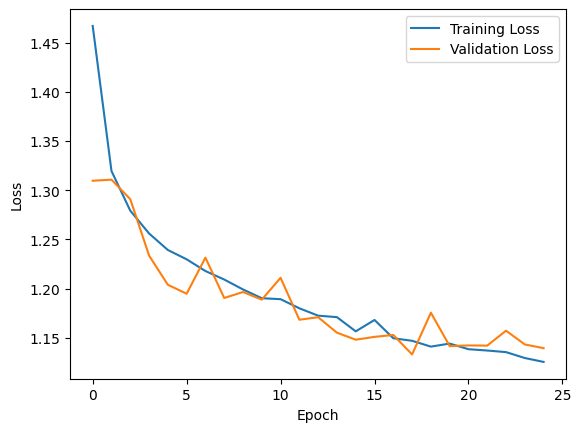

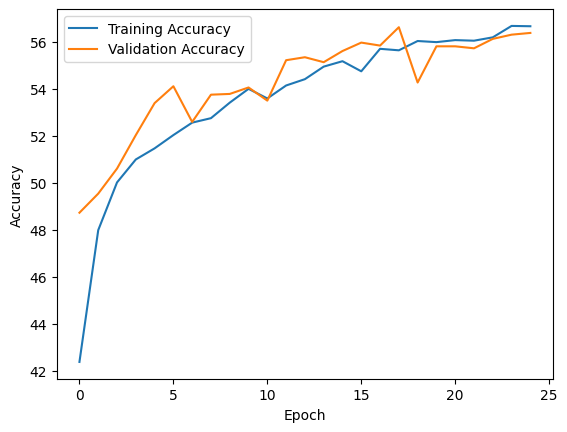

In [16]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=train_transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=test_transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=test_transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate the best model on the test set


In [18]:
def load_and_evaluate_best_model(model, testloader, criterion, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    print("Evaluating best model on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate final metrics
    test_loss = running_loss / len(testloader)
    test_accuracy = 100 * correct / total

    print(f"\nTest Results (Best Model):")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy, all_preds, all_labels

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_28692\3579996063.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:21<00:00,  3.44it/s]


Test Results (Best Model):
Test Loss: 1.1429
Test Accuracy: 55.59%


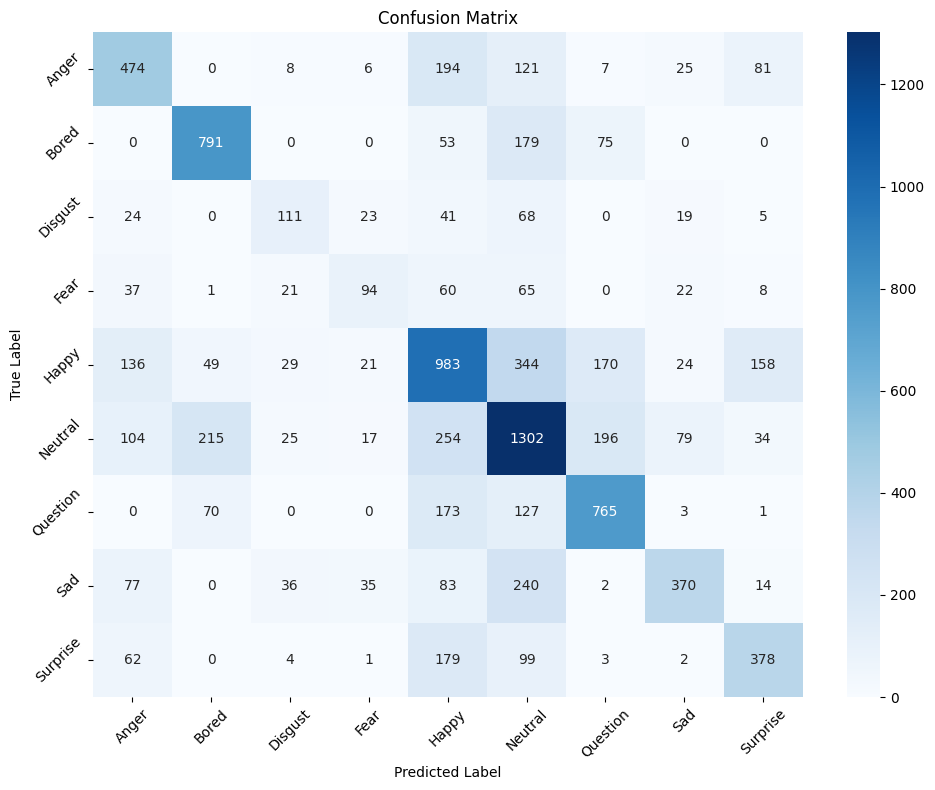

In [19]:
# Load and evaluate the best model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
test_loss, test_accuracy, all_preds, all_labels = load_and_evaluate_best_model(
    model=model,
    testloader=testloader,
    criterion=criterion,
    device=device,
    model_path=best_model_path
)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)